In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks

import keras
from sklearn.metrics import classification_report

from collections import deque

import joblib

### Dataset exploration
understanding the data set, import libraries and load the dataset

In [2]:
# Define root directory paths
file_path = "../../../combined_data.csv"
df = pd.read_csv(file_path)

In [3]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15858929 entries, 0 to 15858928
Data columns (total 12 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   subject     object
 1   activity    object
 2   trial       object
 3   x_ADXL345   int64 
 4   y_ADXL345   int64 
 5   z_ADXL345   int64 
 6   x_ITG3200   int64 
 7   y_ITG3200   int64 
 8   z_ITG3200   int64 
 9   x_MMA8451Q  int64 
 10  y_MMA8451Q  int64 
 11  z_MMA8451Q  int64 
dtypes: int64(9), object(3)
memory usage: 1.4+ GB


In [4]:
# Display the first few rows
df.head()

,subject,activity,trial,x_ADXL345,y_ADXL345,z_ADXL345,x_ITG3200,y_ITG3200,z_ITG3200,x_MMA8451Q,y_MMA8451Q,z_MMA8451Q
0,SA01,D01,R01,17,-179,-99,-18,-504,-352,76,-697,-279
1,SA01,D01,R01,15,-174,-90,-53,-568,-306,48,-675,-254
2,SA01,D01,R01,1,-176,-81,-84,-613,-271,-2,-668,-221
3,SA01,D01,R01,-10,-180,-77,-104,-647,-227,-34,-697,-175
4,SA01,D01,R01,-21,-191,-63,-128,-675,-191,-74,-741,-133


In [5]:
# No. of rows and columns in the dataset
df.shape

(15858929, 12)

In [6]:
# Statistical measures of columns in the dataset
df.describe()

,x_ADXL345,y_ADXL345,z_ADXL345,x_ITG3200,y_ITG3200,z_ITG3200,x_MMA8451Q,y_MMA8451Q,z_MMA8451Q
count,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07
mean,-1.237190e+00,-1.787412e+02,-2.772492e+01,-9.714189e+00,3.517304e+01,-4.465375e+00,-1.889273e+01,-7.005180e+02,-5.936869e+01
std,1.050061e+02,1.499351e+02,1.248853e+02,5.908545e+02,4.895010e+02,3.981378e+02,4.086284e+02,5.827475e+02,5.061164e+02
min,-4.096000e+03,-4.096000e+03,-4.096000e+03,-3.230300e+04,-1.549100e+04,-1.315000e+04,-8.192000e+03,-8.192000e+03,-8.192000e+03
25%,-2.200000e+01,-2.530000e+02,-9.200000e+01,-7.600000e+01,-1.800000e+01,-3.300000e+01,-9.700000e+01,-9.900000e+02,-3.170000e+02
50%,2.000000e+00,-2.300000e+02,-3.100000e+01,-1.100000e+01,3.800000e+01,-5.000000e+00,1.000000e+00,-9.050000e+02,-6.800000e+01
75%,2.600000e+01,-5.400000e+01,3.300000e+01,6.500000e+01,9.400000e+01,2.300000e+01,8.200000e+01,-2.090000e+02,1.850000e+02
max,4.094000e+03,4.092000e+03,4.091000e+03,3.276700e+04,1.581900e+04,1.379800e+04,8.191000e+03,8.191000e+03,8.191000e+03


In [7]:
# Check for missing values in the entire dataset
missing_values = df.isnull().sum()

missing_values

subject       0
activity      0
trial         0
x_ADXL345     0
y_ADXL345     0
z_ADXL345     0
x_ITG3200     0
y_ITG3200     0
z_ITG3200     0
x_MMA8451Q    0
y_MMA8451Q    0
z_MMA8451Q    0
dtype: int64

### Data Cleaning

In [8]:
# Drop Redundant Columns

#drop last sensor values as we are using an accelerometer very similar to ADXL345 - unrelated columns add noise

# Drop the columns related to MMA8451Q
columns_to_drop = ['x_MMA8451Q', 'y_MMA8451Q', 'z_MMA8451Q']
df = df.drop(columns=columns_to_drop)

In [9]:
# Finding out the no. or subjects, activities and trials that has been carried out
print("Unique subjects:", df.subject.nunique())
print("Unique activities:", df.activity.nunique())
print("Unique trials:", df.trial.nunique())
# No of activities per trials vary.
# Some activities have only one trials, but some activities have upto 5 trials.

Unique subjects: 38
Unique activities: 34
Unique trials: 6


**Addressing Labeling Errors**

In the dataset descriptions it says that all activities are recorded only upto 5 trials (uptp R05) but here it says there are R06 also.

To understand where this happens, rows with R06 should be checked deep.

In [10]:
df.trial.unique()

array(['R01', 'R02', 'R03', 'R04', 'R05', 'R06'], dtype=object)

In [11]:
df[df['trial'] == 'R06'].head(2)

,subject,activity,trial,x_ADXL345,y_ADXL345,z_ADXL345,x_ITG3200,y_ITG3200,z_ITG3200
15517542,SE14,D07,R06,-8,-239,-94,-59,42,-5
15517543,SE14,D07,R06,-5,-242,-102,-60,45,-8


In [12]:
# Filter the data for subject 'SE14' and activity 'D07'
se14_d07_data = df[(df['subject'] == 'SE14') & (df['activity'] == 'D07')]

# Get unique combinations of subject, activity, and trial
unique_combinations = se14_d07_data[['subject', 'activity', 'trial']].drop_duplicates()

unique_combinations

,subject,activity,trial
15507943,SE14,D07,R01
15510342,SE14,D07,R02
15512742,SE14,D07,R03
15515142,SE14,D07,R05
15517542,SE14,D07,R06


It can be seen that in the SE14's D07 activity recording, a mistake have been made, where they have names R04 as R05 and R05 as R06. They have skipped R04.

Solution - Renaming R05 as R04 and R06 as R05

In [13]:
# Filter the data for subject 'SE14' and activity 'D07'
se14_d07_data = df[(df['subject'] == 'SE14') & (df['activity'] == 'D07')]

# Rename R05 as R04 and R06 as R05 in the trial column using .loc
df.loc[(df['subject'] == 'SE14') & (df['activity'] == 'D07'), 'trial'] = df.loc[(df['subject'] == 'SE14') & (df['activity'] == 'D07'), 'trial'].replace({'R05': 'R04', 'R06': 'R05'})

# Verify the changes
df[['subject', 'activity', 'trial']].drop_duplicates()

,subject,activity,trial
0,SA01,D01,R01
19999,SA01,D02,R01
39999,SA01,D03,R01
59999,SA01,D04,R01
79999,SA01,D05,R01
...,...,...,...
15821931,SE15,D16,R01
15824330,SE15,D16,R02
15826730,SE15,D16,R03
15829130,SE15,D16,R04


### Feature Engineering

**Label Encoding**

Creating a binary `label` column: 1 for falls, 0 for non-falls.

In [14]:
df['label'] = df['activity'].apply(lambda x: 1 if x[0] == 'F' else 0)
# label= 1 (Fall)
# label= 0 (Non Fall)

**Grouping the data frame into sets of sequences - each group represnets one sample**

In [15]:
# Group the DataFrame by subject, activity and trial
grouped = df.groupby(['subject', 'activity', 'trial'])

In [16]:
grouped.size()

subject  activity  trial
SA01     D01       R01      19999
         D02       R01      20000
         D03       R01      20000
         D04       R01      20000
         D05       R01       5000
                            ...  
SE15     D17       R01       9999
                   R02      10000
                   R03      10000
                   R04      10000
                   R05      10000
Length: 4500, dtype: int64

### Class Distribution

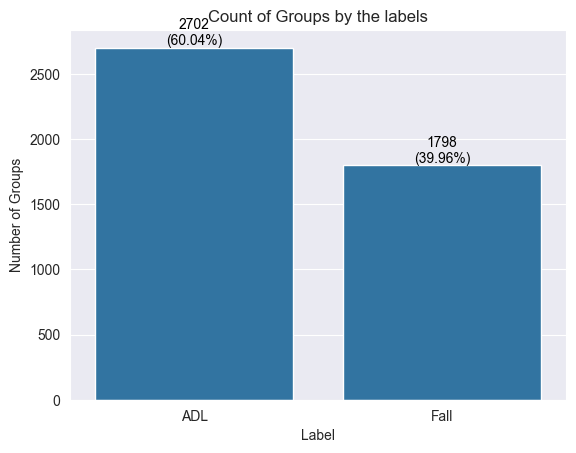

In [17]:
# Computing the mean of each group
grouped_mean = grouped.mean()

# Calculate class times and percentages
class_counts = grouped_mean['label'].value_counts()
class_percentages = (class_counts / class_counts.sum()) * 100

# Check the class distribution
ax = sns.countplot(x='label', data=grouped_mean)

# Add annotations for counts and percentages
for p, count, perc in zip(ax.patches, class_counts, class_percentages):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count}\n({perc:.2f}%)', xy=(x, y), ha='center', va='bottom', fontsize=10, color='black')


# Set labels and title for better readability
plt.xlabel('Label')
plt.ylabel('Number of Groups')
plt.title('Count of Groups by the labels')
plt.xticks([0, 1], ['ADL', 'Fall'])  # Labeling 0 as ADL and 1 as Fall
plt.show()


- The dataset is imbalanced, with a higher proportion of non-fall groups compared to fall groups.
- The class imbalance will need to be addressed during the modeling stage (e.g., resampling, weighted loss) to ensure the model does not favor the majority class (non-falls).

Reason for Imbalance:

The imbalance in the dataset arises because elderly participants predominantly performed Activities of Daily Living (ADLs) and avoided simulated falls due to medical conditions and physician recommendations.

As stated in the dataset description:

Elderly people between 60 and 75 years old only simulated ADLs, except for one participant (SE06) who is an expert in Judo and performed fall simulations.
Certain activities (e.g., D06, D13, D18, D19) were not performed by elderly subjects due to:
Medical recommendations from a physician specializing in sports.
Personal impairments or medical conditions.
This results in a higher number of non-fall activities (ADLs) compared to fall simulations, leading to the observed class imbalance.

### Pattern Trimming

**Ensure all groups have consistent time series lengths**
According to the above description, it can be seen that different activities have different lengths in time.
- Activities D01 - D04 are recorded for 100s, which includes 20000 data rows, (200 per second)
- Activities D05, D06 and D17 are recorded for 25 seconds and have 500 data rows per sample
- ALl the Falls are recorded for 15 seconds and have 3000 data rows per sample
- All other activities are of 12 seconds only, which has only 2400 rows

If the time series lengths of groups are inconsistent, several issues can arise, particularly during modeling and preprocessing:
- Models like LSTMs and CNNs require inputs with fixed dimensions.
- Impact on feature engineering - challenging to directly feed the data into the models.
- When aggregating group data (e.g., computing means or sums), inconsistent lengths can bias the statistics. Shorter groups will have fewer data, leading to incorrect averages.

Solution the groups of long sequences will be truncated.

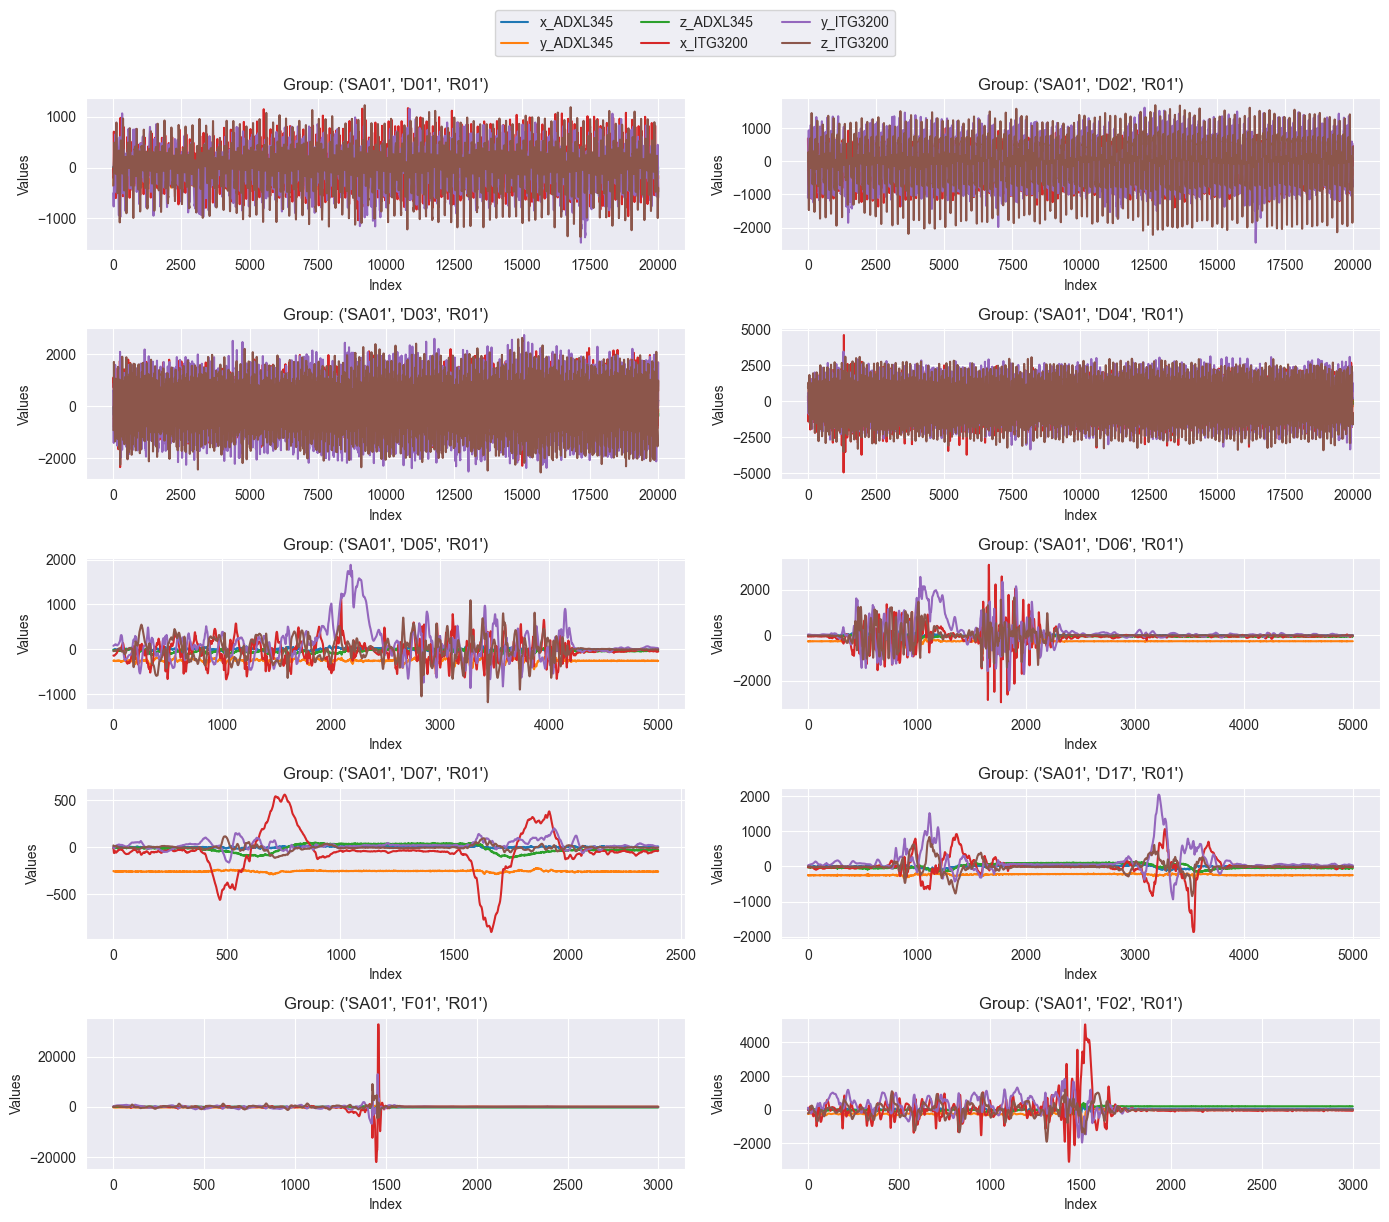

In [18]:
# To have an idea of what does data from long sequences look like one sample from each case will be printed out.

# Define the specific activities you want to plot
selected_activities = ["D01", "D02", "D03", "D04", "D05", "D06", "D07", "D17", "F01", "F02"]

# Create a list to hold one group from each activity
groups_to_plot = []

# Iterate over selected activities and pick the first matching group for each activity
for activity in selected_activities:
    for group_key in grouped.groups.keys():
        if activity in group_key:
            groups_to_plot.append(group_key)
            break  # Break after finding the first matching group for the activity

# Ensure we have only 10 groups
groups_to_plot = groups_to_plot[:10]

# Create subplots: 10 plots in a grid of 5 rows × 2 columns
fig, axes = plt.subplots(5, 2, figsize=(14, 12))
axes = axes.flatten()  # Flatten axes for easier access

# Initialize a variable to capture the legend handles and labels
handles, labels = None, None

# Plot each selected group
for i, group_key in enumerate(groups_to_plot):
    # Extract the group's data
    group_data = grouped.get_group(group_key)
    
    # Reset the index so x-values start from 0
    group_data_reset = group_data.reset_index(drop=True)
    
    # Drop identifiers and plot the remaining sensor data
    ax = axes[i]
    plot = group_data_reset.drop(['subject', 'activity', 'trial', 'label'], axis=1, errors='ignore').plot(
        ax=ax, title=f"Group: {group_key}", legend=False  # Only capture the legend once
    )
    
    # Capture the legend handles and labels (from the first plot)
    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()

    ax.set_xlabel("Index")
    ax.set_ylabel("Values")

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a single legend outside the plot grid
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02))

# Improve layout
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit the legend
plt.show()


In the above figure the groups with long sequences is plotted.
- D01 (100s - 20 000)
- D02 (100s - 20 000)
- D03 (100s - 20 000)
- D04 (100s - 20 000)
- D05 (25s - 5000)
- D06 (25s - 5000)
- D07 (12s - 2400) // lowest sequence
- D17 (25s - 5000)

**Data Trimming for Fall Detection Analysis**

During the analysis of the sensor data, it became clear that when the data was limited to 12 seconds, the patterns were much more distinct and visible. In contrast, when the data contained a longer duration (in the 100s), the patterns were less visible, and it became challenging to interpret the underlying behavior. Additionally, in these longer time frames, the patterns appeared to be more recursive, making it harder to pinpoint the specific actions.

To make the patterns clearer and to ensure consistent analysis across different activities, I will apply the following trimming strategy:

Trimming Strategy:
- For Activities D01, D02, D03, D04: Trim to the middle 12 seconds of the data.
- For Activity D05: Trim to the middle 12 seconds.
- For Activity D06: Trim to the first 12 seconds of the data.
- For Activity D17: Trim to the middle 12 seconds.
- For All Fall Activities (15 seconds): Trim to the first 12 seconds of the data.

Reasoning Behind Trimming:
- Fall activities are only 15 seconds long, and for consistency, I will keep only the first 12 seconds for all fall-related data.
- For non-fall activities with variable durations, I chose specific trimming methods to retain the most meaningful part of the data based on the activity duration and sensor patterns.

This trimming step ensures that all data used in the analysis are of uniform length (12 seconds) and can be fairly compared without discrepancies due to varying event durations.

In [19]:
# Define the activities that need the middle 12 seconds
selected_activities_first = ["D01", "D02", "D03", "D04", "D05", "D17"]

# Define the activities that need the first 12 seconds
selected_activities_second = ["D07", "D08", "D09", "D10", "D11", "D12", "D13", "D14", 
                              "D15", "D16", "D18", "D19", "D06", "F01", "F02", "F03", 
                              "F04", "F05", "F06", "F07", "F08", "F09", "F10", "F11", 
                              "F12", "F13", "F14", "F15"]

# Create an empty list to store the filtered data for these groups
filtered_groups_first = []
filtered_groups_second = []

# Iterate over each group in 'grouped' for first set of activities
for group_key, group_data in grouped:
    # Check if the activity is one of the selected activities for the first set (middle 12 seconds)
    if any(activity in group_key for activity in selected_activities_first):
        total_rows = len(group_data)
        
        # Calculate the number of rows to trim based on the total row count
        rows_to_trim = (total_rows - 2400) // 2  # Keep 2400 rows in the middle
        
        # Trim the rows dynamically, for both even and odd row counts
        middle_12_seconds = group_data.iloc[rows_to_trim:-rows_to_trim]
        
        # Check if the number of rows is 2401 (i.e., odd number), remove the last row if necessary
        if len(middle_12_seconds) > 2400:
            middle_12_seconds = middle_12_seconds.iloc[:2400]  # Remove the last row
        
        # Append the trimmed group to the list
        filtered_groups_first.append(middle_12_seconds)

# Iterate over each group in 'grouped' for second set of activities
for group_key, group_data in grouped:
    # Check if the activity is one of the selected activities for the second set (first 12 seconds)
    if any(activity in group_key for activity in selected_activities_second):
        # Trim to keep the first 12 seconds
        first_12_seconds = group_data.iloc[:2400]
        
        # Append the trimmed group to the list
        filtered_groups_second.append(first_12_seconds)

# Concatenate the filtered groups from both sets of activities into one DataFrame
trimmed_df = pd.concat(filtered_groups_first + filtered_groups_second)

# Group the data by subject, activity, and trial
trimmed_groups = trimmed_df.groupby(['subject', 'activity', 'trial'])

# Print the size of each group after trimming to verify
print(trimmed_groups.size())

subject  activity  trial
SA01     D01       R01      2400
         D02       R01      2400
         D03       R01      2400
         D04       R01      2400
         D05       R01      2400
                            ... 
SE15     D17       R01      2400
                   R02      2400
                   R03      2400
                   R04      2400
                   R05      2400
Length: 4500, dtype: int64


In [20]:
trimmed_groups.size().unique()

array([2400, 2399, 2398, 2395, 2394, 2396, 2001, 1999, 2000])

In [21]:
grouped.size().unique()

array([19999, 20000,  5000,  2400,  4999,  3000,  2999,  2399,  3001,
        3006,  5005,  2982,  2981,  4981,  5001,  2998,  2996,  2398,
        2395,  2997, 19997,  4998,  2394,  2396,  2891, 35999, 36000,
        2401,  2001,  1999,  2000,  5406,  4605,  5008,  4205,  4603,
        3204,  3205,  3607, 20001, 22006,  4606,  5011,  4806,  4206,
        3807,  4006,  5007,  3404,  3405,  3804,  2404, 19995, 19985,
       19998, 19996,  4993,  4997, 19990,  9999, 10000])

According to the dataset description it says the least time an activity was recorded was 12 seconds (which should mean that the minimum size of these groups should be 2400) But for some reason some groups have different sizes which should be taken care of.

In [22]:
group_sizes = grouped.size()
group_sizes[group_sizes < 2400].unique()

array([2399, 2398, 2395, 2394, 2396, 2001, 1999, 2000])

Since all these values have only minor differences (information of less than one second), these can be handled by duplicating their last row until they reach 2400 rows. This could give the meaning that the same acceleration or angular velocity has been there until the end.

In [23]:
# Function to pad groups with fewer than 2400 rows by duplicating the last row
def pad_with_last_row(group):
    current_size = len(group)
    if current_size < 2400:
        # Calculate how many rows are needed
        rows_to_add = 2400 - current_size
        # Repeat the last row as needed and concatenate
        last_row = group.iloc[[-1]]  # Select the last row as a DataFrame
        padding = pd.concat([last_row] * rows_to_add, ignore_index=True)
        # Concatenate the original group with the padding
        group = pd.concat([group, padding], ignore_index=True)
    return group

# Apply the function to all groups in the DataFrame
trimmed_df = (
    trimmed_df.groupby(['subject', 'activity', 'trial'], group_keys=False)
    .apply(pad_with_last_row)
)

# Verify that all groups now have 2400 rows
print(trimmed_df.groupby(['subject', 'activity', 'trial']).size().unique())

C:\Users\Senuli\AppData\Local\Temp\ipykernel_15960\3881650366.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pad_with_last_row)


[2400]


In [24]:
trimmed_groups = trimmed_df.groupby(['subject', 'activity', 'trial'])
trimmed_groups.size()

subject  activity  trial
SA01     D01       R01      2400
         D02       R01      2400
         D03       R01      2400
         D04       R01      2400
         D05       R01      2400
                            ... 
SE15     D17       R01      2400
                   R02      2400
                   R03      2400
                   R04      2400
                   R05      2400
Length: 4500, dtype: int64

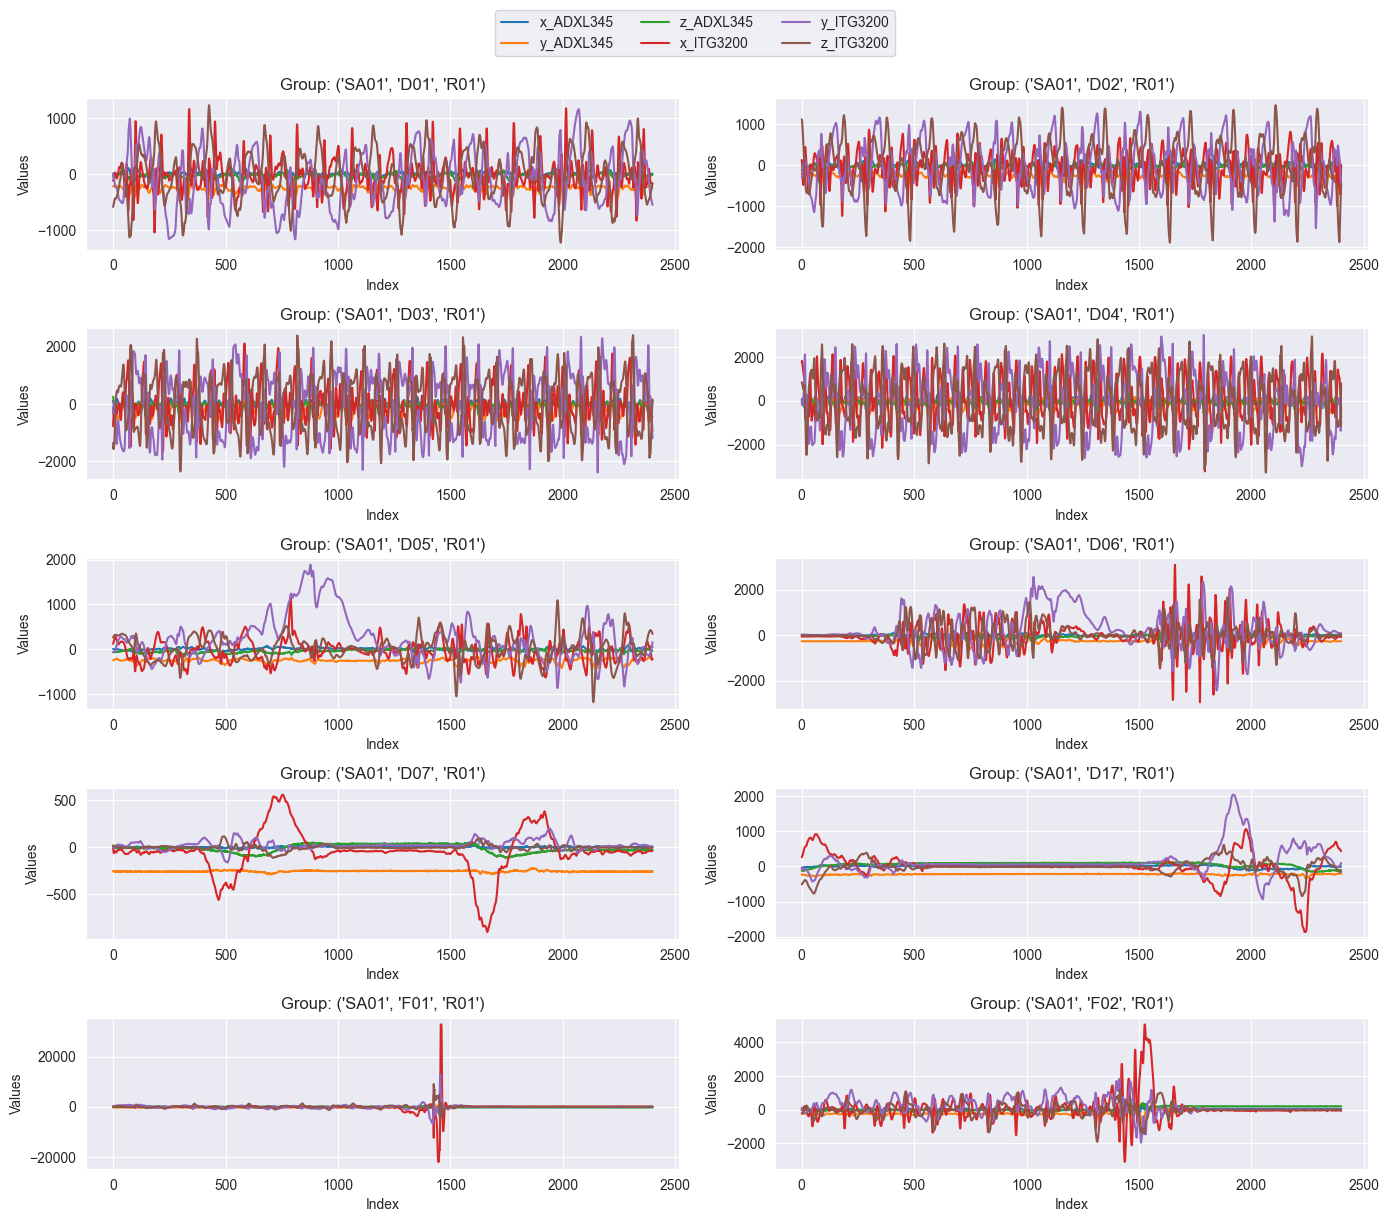

In [25]:
# To plot the trimmed group for verification

# Define the specific activities you want to plot
selected_activities = ["D01", "D02", "D03", "D04", "D05", "D06", "D07", "D17", "F01", "F02"]

# Create a list to hold one group from each activity
groups_to_plot = []

# Iterate over selected activities and pick the first matching group for each activity
for activity in selected_activities:
    for group_key in trimmed_groups.groups.keys():
        if activity in group_key:
            groups_to_plot.append(group_key)
            break  # Break after finding the first matching group for the activity

# Ensure we have only 10 groups
groups_to_plot = groups_to_plot[:10]

# Create subplots: 10 plots in a grid of 5 rows × 2 columns
fig, axes = plt.subplots(5, 2, figsize=(14, 12))
axes = axes.flatten()  # Flatten axes for easier access

# Initialize a variable to capture the legend handles and labels
handles, labels = None, None

# Plot each selected group
for i, group_key in enumerate(groups_to_plot):
    # Extract the group's data
    group_data = trimmed_groups.get_group(group_key)
    
    # Reset the index so x-values start from 0
    group_data_reset = group_data.reset_index(drop=True)
    
    # Drop identifiers and plot the remaining sensor data
    ax = axes[i]
    plot = group_data_reset.drop(['subject', 'activity', 'trial', 'label'], axis=1, errors='ignore').plot(
        ax=ax, title=f"Group: {group_key}", legend=False  # Only capture the legend once
    )
    
    # Capture the legend handles and labels (from the first plot)
    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()

    ax.set_xlabel("Index")
    ax.set_ylabel("Values")

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a single legend outside the plot grid
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02))

# Improve layout
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit the legend
plt.show()

The data groups are now perfectly aligned, with all groups normalized to 2400 rows, ensuring consistency and clarity for further analysis.

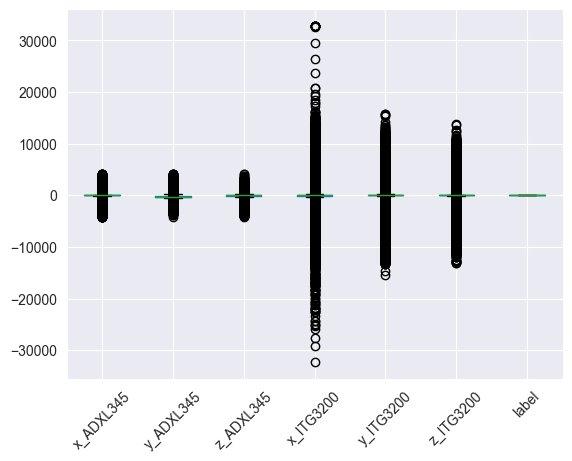

In [26]:
# Check for Outliers
trimmed_df.boxplot()

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()

### Handling Outliers

Outliers in sensor data, such as sudden changes in acceleration or angular velocity, are critical for fall detection as they often signify the sharp movements associated with falls. Instead of being treated as noise or errors, these outliers are considered key indicators of potential fall events. For instance:

- **Acceleration spikes**: Represent sudden and high-impact movements during a fall.
- **Angular velocity changes**: Depict rotational motions or body twists common in falls.

To leverage these outliers effectively:
- Threshold-based detection identifies potential falls when sensor values exceed predefined limits.
- Temporal patterns are analyzed to distinguish meaningful outliers from noise, focusing on bursts of activity over short time windows.
- These outliers are retained as essential features for training machine learning models to classify falls accurately.

This approach ensures that critical fall events are captured and not inadvertently removed during preprocessing.

### Plotting one sample from each activity

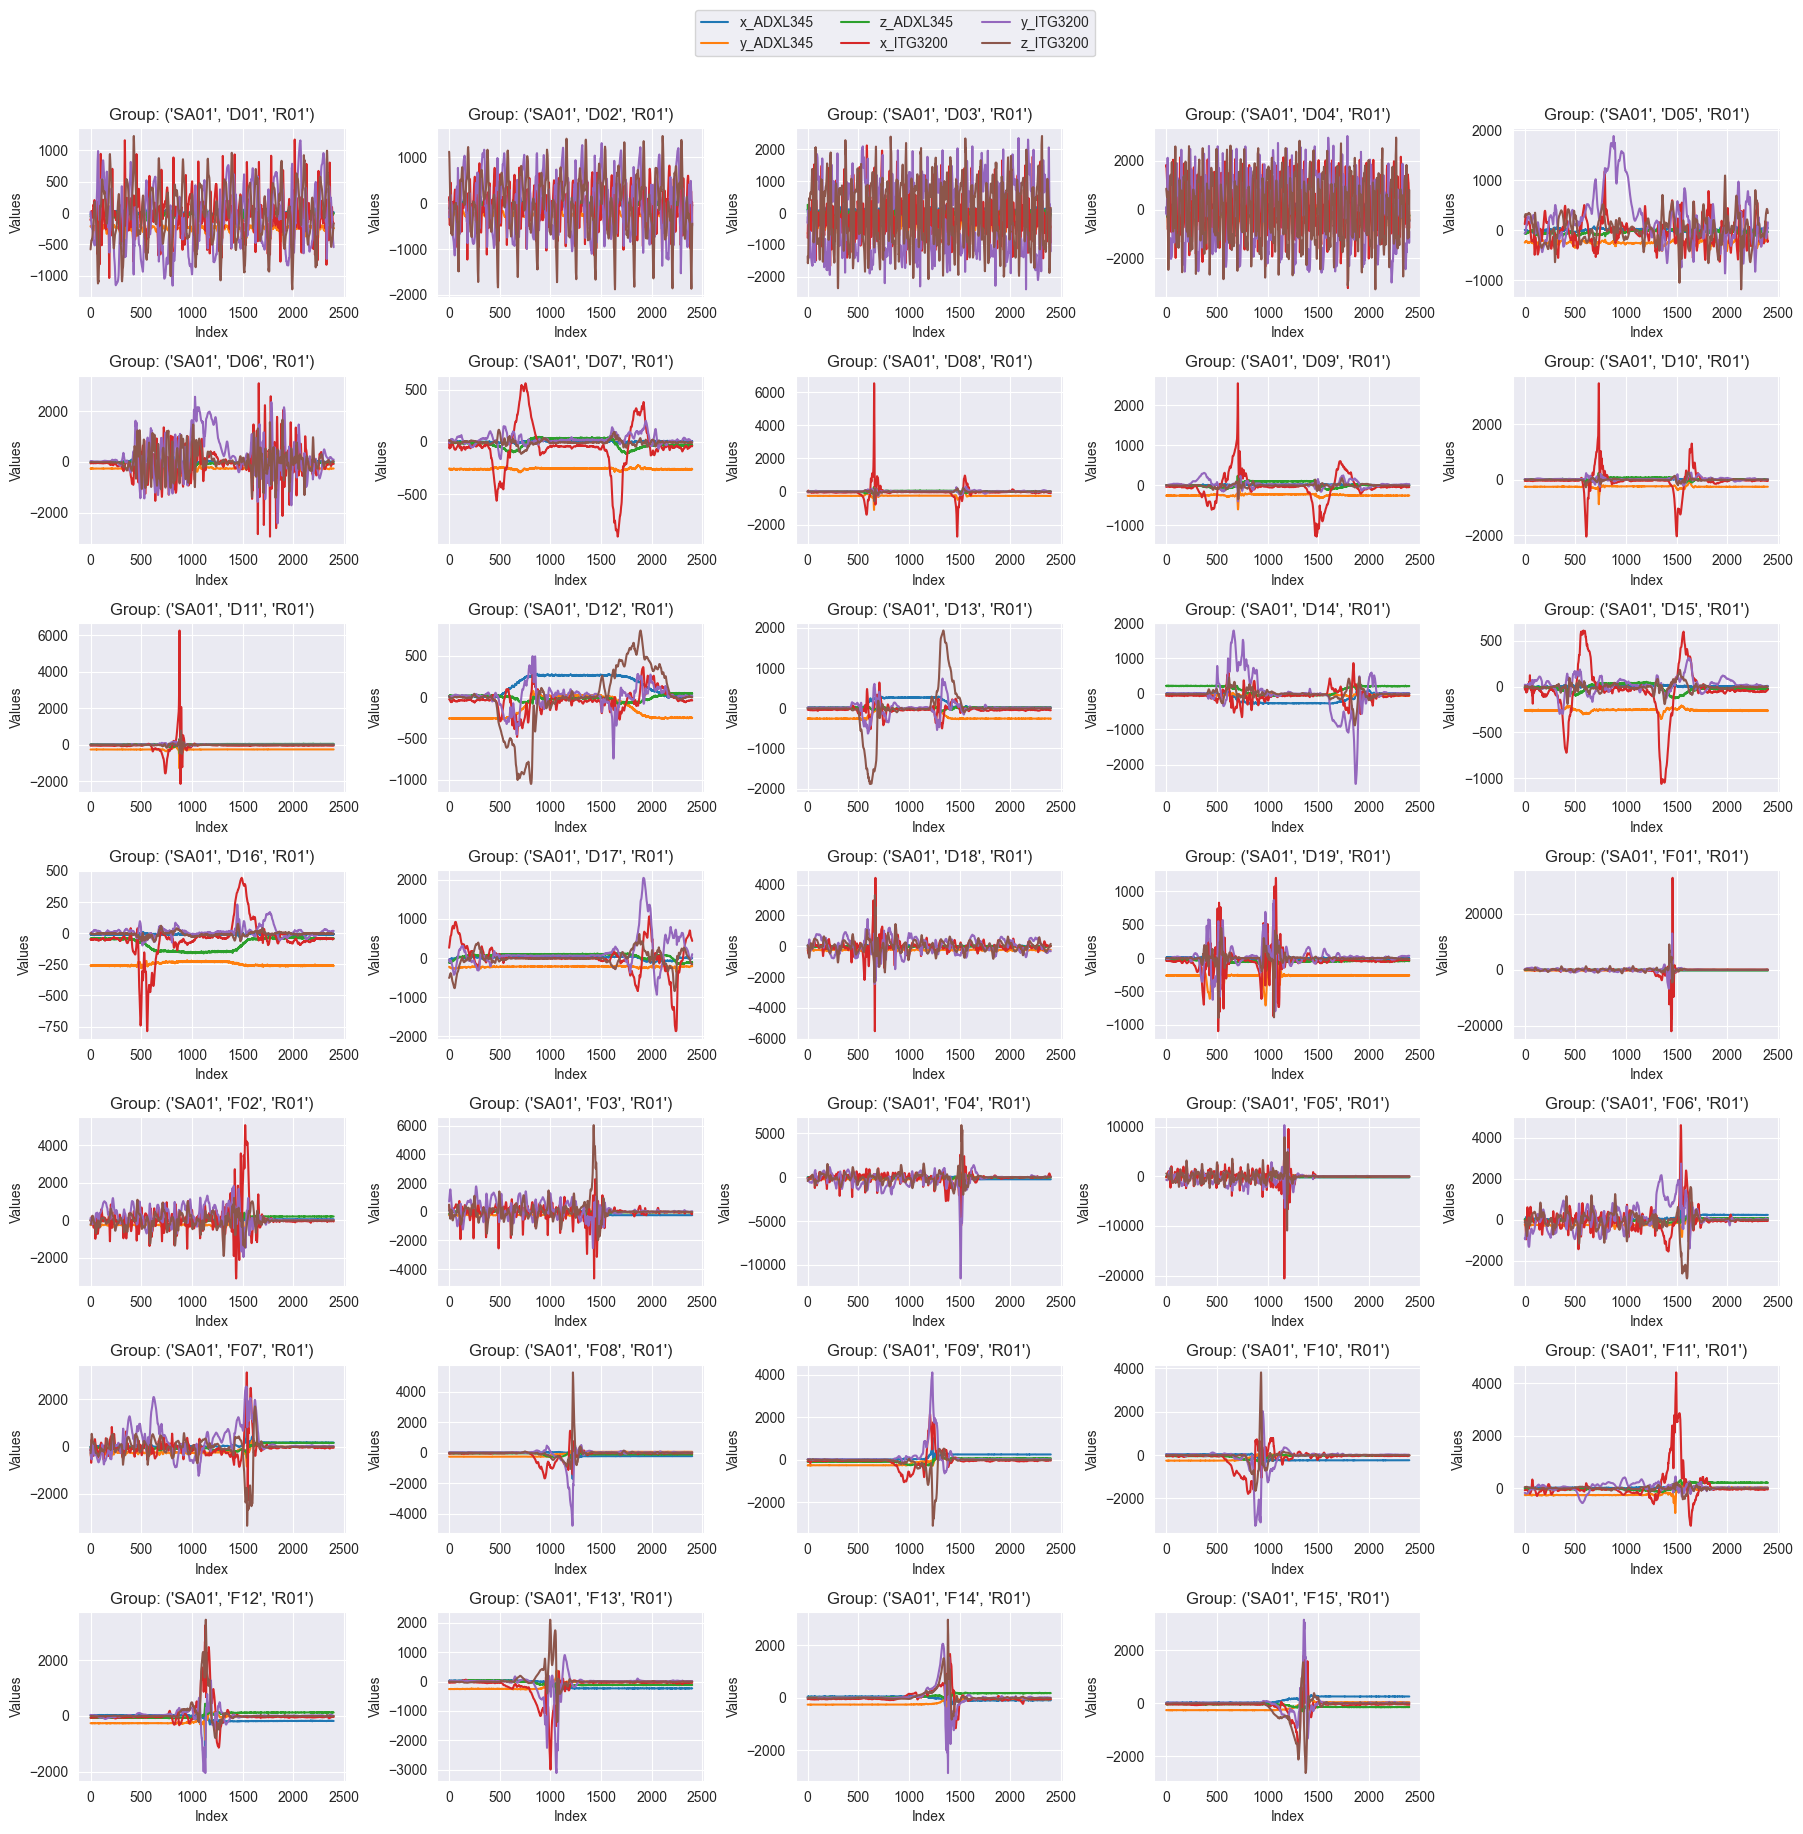

In [27]:
# Plotting one sample from each activity

# Get the unique activities in your dataset (assuming 'activity' column holds activity types)
unique_activities = trimmed_df['activity'].unique()

# Create a list to hold one group from each activity
groups_to_plot = []

# Iterate over unique activities and pick the first matching group for each activity
for activity in unique_activities:
    for group_key in grouped.groups.keys():
        if activity in group_key:
            groups_to_plot.append(group_key)
            break  # Break after finding the first matching group for the activity

# Ensure we have one group per activity (total 34 activities)
groups_to_plot = groups_to_plot[:34]

# Create subplots: 34 plots in a grid of 7 rows × 5 columns
fig, axes = plt.subplots(7, 5, figsize=(18, 18))
axes = axes.flatten()  # Flatten axes for easier access

# Initialize a variable to capture the legend handles and labels
handles, labels = None, None

# Plot each selected group
for i, group_key in enumerate(groups_to_plot):
    # Extract the group's data
    group_data = trimmed_groups.get_group(group_key)
    
    # Reset the index so x-values start from 0
    group_data_reset = group_data.reset_index(drop=True)
    
    # Drop identifiers and plot the remaining sensor data
    ax = axes[i]
    plot = group_data_reset.drop(['subject', 'activity', 'trial', 'label'], axis=1, errors='ignore').plot(
        ax=ax, title=f"Group: {group_key}", legend=False  # Only capture the legend once
    )
    
    # Capture the legend handles and labels (from the first plot)
    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()

    ax.set_xlabel("Index")
    ax.set_ylabel("Values")

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a single legend outside the plot grid
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02))

# Improve layout
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit the legend
plt.show()

### Train Test Validation Set Splitting

In [28]:
# Train Test Validation Set Splitting

trimmed_df['index'] = trimmed_df['subject'].astype(str) + '_' + trimmed_df['trial'].astype(str) + '_' + trimmed_df['activity']

# Keep subject separate for splitting
subjects = trimmed_df['subject'].unique()

# Split subjects first (not the data)
train_subjects, temp_subjects = train_test_split(subjects, test_size=0.4, random_state=42)
val_subjects, test_subjects = train_test_split(temp_subjects, test_size=0.5, random_state=42)

# Then filter the groups based on subjects
train_groups = [group for name, group in trimmed_groups if any(subj in name for subj in train_subjects)]
val_groups = [group for name, group in trimmed_groups if any(subj in name for subj in val_subjects)]
test_groups = [group for name, group in trimmed_groups if any(subj in name for subj in test_subjects)]

# Reconstruct DataFrames for each split
train_df = pd.concat(train_groups)
val_df = pd.concat(val_groups)
test_df = pd.concat(test_groups)

# Display the size of each split
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")
print(f"Test set size: {test_df.shape}")

Training set size: (6292800, 11)
Validation set size: (2498400, 11)
Test set size: (2008800, 11)


### 3D Matrix Conversion

The sensor data was converted into **3D matrices** to preserve the temporal structure of the time-series data. Each sample, representing a trial (e.g., an activity or fall), consists of sensor readings taken at multiple time steps. By organizing the data into the format **(samples × time steps × features)**, we can capture the sequential relationships between sensor values across time.

This 3D structure is crucial for models such as **1D Convolutional Neural Networks (CNN)** and **Temporal Convolutional Networks (TCN)**, which are designed to learn temporal dependencies in sequential data. These models require a 3D input to process the time-series data effectively and detect patterns in the sensor readings that may indicate specific activities or falls.

In [29]:
# Extract features and labels from grouped data
sensor_columns = ['x_ADXL345', 'y_ADXL345', 'z_ADXL345',
                 'x_ITG3200', 'y_ITG3200', 'z_ITG3200']

# Convert groups to numpy arrays
X_train = np.array([group[sensor_columns].values for group in train_groups])
X_val = np.array([group[sensor_columns].values for group in val_groups])
X_test = np.array([group[sensor_columns].values for group in test_groups])

y_train = np.array([group['label'].iloc[0] for group in train_groups])
y_val = np.array([group['label'].iloc[0] for group in val_groups])
y_test = np.array([group['label'].iloc[0] for group in test_groups])

# Store original shapes
original_shape_train = X_train.shape
original_shape_val = X_val.shape
original_shape_test = X_test.shape

### Extract Informative Segments

This function extracts the most informative segment from each time series sample based on peak detection. The goal is to focus on key segments of the time series that capture the most significant features or patterns, potentially reducing the data size without losing critical information.

For each sample in the input data, the function detects peaks in the sensor readings across all features. The largest peak is identified, and a segment surrounding it is extracted. This segment is then used as the most informative part of the time series, allowing the model to focus on the most significant part of the data. This approach can help improve model performance by reducing noise and irrelevant information.

In [30]:
def extract_informative_segments(X, segment_length=1000):
    """
    Extracts the most informative segment from each time series sample based on peaks.
    """
    n_samples, n_timestamps, n_features = X.shape
    extracted_segments = np.zeros((n_samples, segment_length, n_features))

    for i in range(n_samples):
        sample = X[i]  # Shape: (n_timestamps, n_features)
        segment_start = 0  # Default to the start of the series
        for j in range(n_features):
            feature_data = sample[:, j]
            # Find peaks in the feature data
            peaks, _ = find_peaks(feature_data, distance=segment_length // 2)
            if len(peaks) > 0:
                # Select the largest peak and extract the window around it
                max_peak = peaks[np.argmax(feature_data[peaks])]
                segment_start = max(0, max_peak - segment_length // 2)
                segment_start = min(segment_start, n_timestamps - segment_length)
                break

        # Extract the segment for all features
        extracted_segments[i] = sample[segment_start:segment_start + segment_length, :]

    return extracted_segments

In [31]:
X_train_informative = extract_informative_segments(X_train)
X_val_informative = extract_informative_segments(X_val)
X_test_informative = extract_informative_segments(X_test)

In [32]:
print(X_train_informative.shape, y_train.shape)
print(X_val_informative.shape, y_val.shape)
print(X_test_informative.shape, y_test.shape)

(2622, 1000, 6) (2622,)
(1041, 1000, 6) (1041,)
(837, 1000, 6) (837,)


### Feature Scaling

**Standard Scaling** is applied to the sensor data to ensure that each feature (e.g., x, y, z sensor axes) contributes equally to the model training. Since sensor data can have varying ranges across features, scaling helps prevent features with larger values from dominating the learning process. It also ensures that gradient-based models like **CNN** and **TCN** converge faster and more efficiently.

For **XGBoost**, while scaling is not necessary, it can still improve training consistency and speed. Since tree-based models are not sensitive to feature scales, the impact of scaling on XGBoost is minimal, but it can be beneficial for uniformity across different models.


- **Fit-transform on the training data:**
    - When scaling the data, the scaler is fitted on the training data only. This means the scaler calculates the mean and standard deviation (for StandardScaler) based on the training set. Then the training data will be transformed using these calculated parameters, scaling the features accordingly.

- **Transform only on validation and test data:**
    - For the validation and test data, they are only transformed, using the parameters (mean, standard deviation, min, max) learned from the training data. This ensures that the model is not exposed to the validation or test data during training, preventing data leakage.

In [33]:
# Initialize the scaler
scaler = StandardScaler()

# Scale training data
X_train = scaler.fit_transform(X_train_informative.reshape(-1, X_train_informative.shape[-1])).reshape(X_train_informative.shape)

# Scale test and validation data using the same scaler
X_test = scaler.transform(X_test_informative.reshape(-1, X_test_informative.shape[-1])).reshape(X_test_informative.shape)
X_val = scaler.transform(X_val_informative.reshape(-1, X_val_informative.shape[-1])).reshape(X_val_informative.shape)

In [35]:
# Save the scaler
joblib.dump(scaler, 'acc_gyro_scaler.pkl')  # Save it to a file for later use

['acc_gyro_scaler.pkl']

In [36]:
# Check the shapes
print("Train shape after scaling:", X_train.shape)  # (2622, 1000, 6)
print("Test shape after scaling:", X_test.shape)    # (1041, 1000, 6)
print("Validation shape after scaling:", X_val.shape)  # (837, 1000, 6)

Train shape after scaling: (2622, 1000, 6)
Test shape after scaling: (837, 1000, 6)
Validation shape after scaling: (1041, 1000, 6)


In [37]:
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(2622, 1000, 6) (837, 1000, 6) (1041, 1000, 6)
(2622,) (837,) (1041,)


In [38]:
# Save the datasets
np.save('X_train.npy', X_train_informative)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val_informative)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test_informative)
np.save('y_test.npy', y_test)

In [39]:
X_train = X_train_informative
X_val = X_val_informative
X_test = X_test_informative

### Model Training - CNN

In [3]:
# Load the data
X_train = np.load('Data/X_train.npy')
y_train = np.load('Data/y_train.npy')
X_val = np.load('Data/X_val.npy')
y_val = np.load('Data/y_val.npy')
X_test = np.load('Data/X_test.npy')
y_test = np.load('Data/y_test.npy')

In [4]:
# Best Parameters
best_params = {
    "batch_size": 16,
    "dropout_rate": 0.2,
    "filters": 64,
    "kernel_size": 5,
    "learning_rate": 0.0005
}

# Number of classes
num_classes = len(np.unique(y_train))

In [5]:
# Function to create the model
def make_model(input_shape, filters, kernel_size, dropout_rate):
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Dropout(dropout_rate)(x)

    x = keras.layers.GlobalAveragePooling1D()(x)
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Create and compile the model
model = make_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    filters=best_params["filters"],
    kernel_size=best_params["kernel_size"],
    dropout_rate=best_params["dropout_rate"]
)

optimizer = keras.optimizers.Adam(learning_rate=best_params["learning_rate"])
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

In [6]:
# Train the model with more epochs
best_model_path = "Saved Models/final_best_cnn.keras"
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=8,
    batch_size=best_params["batch_size"],
    verbose=1
)

Epoch 1/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.5680 - sparse_categorical_accuracy: 0.7344 - val_loss: 0.4245 - val_sparse_categorical_accuracy: 0.8156
Epoch 2/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.4381 - sparse_categorical_accuracy: 0.8362 - val_loss: 0.3849 - val_sparse_categorical_accuracy: 0.8559
Epoch 3/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.4228 - sparse_categorical_accuracy: 0.8333 - val_loss: 0.3717 - val_sparse_categorical_accuracy: 0.8770
Epoch 4/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.3909 - sparse_categorical_accuracy: 0.8431 - val_loss: 0.3482 - val_sparse_categorical_accuracy: 0.8818
Epoch 5/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.3698 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.3484 - val_sparse_categorical_accuracy: 0.8818
Epoch 6/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.3783 - sparse_categorical_accuracy: 0.8562 - val_loss: 0.3482 - val_sparse_categorical_accuracy: 0.8847
Epoc

In [10]:
# Save the final model
model.save(best_model_path)

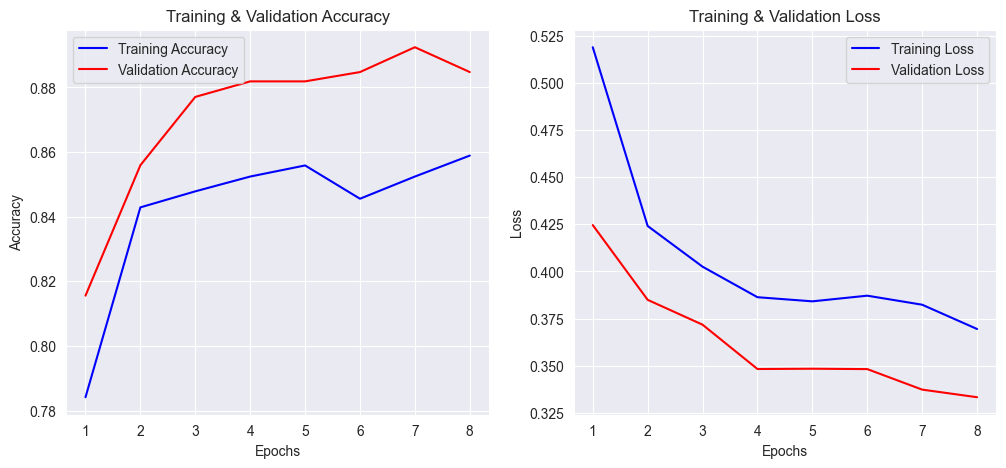

In [9]:
# Plot accuracy and loss curves
epochs = range(1, len(history.history["loss"]) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["sparse_categorical_accuracy"], "b", label="Training Accuracy")
plt.plot(epochs, history.history["val_sparse_categorical_accuracy"], "r", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "b", label="Training Loss")
plt.plot(epochs, history.history["val_loss"], "r", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

In [8]:
# Evaluate the final model
# best_model = keras.models.load_model(best_model_path)
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       539
           1       0.81      0.92      0.86       298

    accuracy                           0.89       837
   macro avg       0.88      0.90      0.88       837
weighted avg       0.90      0.89      0.89       837



In [12]:
joblib.dump(model, 'cnn_sensor_model.pkl')

['cnn_sensor_model.pkl']

### Real Time Data Visualization

**Run the first Cell and wait for it to display the empty plot before running the next cell.**

**The second cell runs for more than an hour. Stop it after like 20 mins (2 or 3 predictions)**

In [3]:
# Setup and Figure Creation

# Enable interactive notebook mode
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

# Load the model and data
model = keras.models.load_model("Saved Models/best_cnn.keras")
X_data = np.load("Data/x_val.npy")

# Set up the figure with adjusted layout for text
fig = plt.figure(figsize=(12, 6))
gs = plt.GridSpec(2, 2, width_ratios=[4, 1])

# Create subplots with GridSpec
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
text_ax = fig.add_subplot(gs[:, 1])

# Set up lines for each axis
line1_x, = ax1.plot([], [], 'r-', label='X-axis')
line1_y, = ax1.plot([], [], 'g-', label='Y-axis')
line1_z, = ax1.plot([], [], 'b-', label='Z-axis')
line2_x, = ax2.plot([], [], 'r-', label='X-axis')
line2_y, = ax2.plot([], [], 'g-', label='Y-axis')
line2_z, = ax2.plot([], [], 'b-', label='Z-axis')

# Set titles and labels
ax1.set_title('Sensor 1')
ax2.set_title('Sensor 2')
ax1.set_xlabel('Time Steps')
ax2.set_xlabel('Time Steps')
ax1.set_ylabel('Value')
ax2.set_ylabel('Value')
ax1.legend()
ax2.legend()

# Set up text display area
text_ax.axis('off')
text_ax.text(0.1, 0.5, "Waiting for predictions...",
             fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
             verticalalignment='center')

# Set fixed axis limits
window_size = 1000
ax1.set_xlim(0, window_size)
ax2.set_xlim(0, window_size)

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>

In [4]:
# Visualization Function
# Run this in a separate cell after the figure is created and stable
def update_prediction_text(prediction, confidence):
    text_ax.clear()
    text_ax.axis('off')
    prediction_text = (f"Current Prediction: {prediction}\n"
                      f"Confidence: {confidence:.2%}")
    text_ax.text(0.1, 0.5, prediction_text,
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                verticalalignment='center')

# Initialize sliding window buffers
times = np.arange(window_size)
sensor1_x = deque([0] * window_size, maxlen=window_size)
sensor1_y = deque([0] * window_size, maxlen=window_size)
sensor1_z = deque([0] * window_size, maxlen=window_size)
sensor2_x = deque([0] * window_size, maxlen=window_size)
sensor2_y = deque([0] * window_size, maxlen=window_size)
sensor2_z = deque([0] * window_size, maxlen=window_size)

# Flatten all samples into one continuous stream
continuous_data = X_data.reshape(-1, X_data.shape[-1])

# Process the continuous data
prediction_buffer = []
for i, data_point in enumerate(continuous_data):
    # Update sensor buffers
    sensor1_x.append(data_point[0])
    sensor1_y.append(data_point[1])
    sensor1_z.append(data_point[2])
    sensor2_x.append(data_point[3])
    sensor2_y.append(data_point[4])
    sensor2_z.append(data_point[5])

    # Update plot lines
    line1_x.set_data(times, list(sensor1_x))
    line1_y.set_data(times, list(sensor1_y))
    line1_z.set_data(times, list(sensor1_z))
    line2_x.set_data(times, list(sensor2_x))
    line2_y.set_data(times, list(sensor2_y))
    line2_z.set_data(times, list(sensor2_z))

    # Collect points for prediction
    prediction_buffer.append(data_point)

    # Make prediction when buffer is full
    if len(prediction_buffer) == window_size:
        # Reshape data for model input
        model_input = np.array(prediction_buffer).reshape(1, window_size, 6)

        # Get prediction
        prediction = model.predict(model_input, verbose=0)
        predicted_class = np.argmax(prediction[0])
        prediction_probability = prediction[0][predicted_class]

        # Update prediction text
        predicted_label = "Fall" if predicted_class == 1 else "Non-Fall"
        update_prediction_text(predicted_label, prediction_probability)

        # Clear prediction buffer but keep last 100 points for overlap
        prediction_buffer = prediction_buffer[-100:]

    # Adjust y-axis limits
    ax1.relim()
    ax2.relim()
    ax1.autoscale_view(scalex=False)
    ax2.autoscale_view(scalex=False)

    # Update the plot
    fig.canvas.draw()

    # Add a small delay
    # time.sleep(0.001)

KeyboardInterrupt: 